Start by Importing Libraries

In [ ]:
# importing all necessary libraries to run the code
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import NaiveBayesClassifier
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
import re
# DataFrame
import pandas as pd 

# plotting
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
sw = stopwords.words('english')

# rnn
from keras.models import Sequential
from keras.layers import Dense

# saving file
import pickle

# word embedding
import io
import re
import string
import tqdm

import numpy as np

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras import regularizers

import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Define functions that will be used in the project

In [ ]:
# define functions

def save_model(model):
  file = open('4483_model','wb')
  pickle.dump(model, file)
  file.close()

def save_vectorizer(vectorizer):
  file = open('4483_vectorizer','wb')
  pickle.dump(vectorizer, file)
  file.close()

def vector_to_binary(y_pred):
  binary_prediction = []
  for i in y_pred:
    if i[0] >= 0.5:
      binary_prediction.append(1)
    else:
      binary_prediction.append(0)
  return binary_prediction

def cleaning_data(data):
  aux_list = []
  flag = False
  for phase_word in data:
      word_list = []
      for word in phase_word.split():
          word = word.lower()
          if flag and not word in sw:
              flag = False
              word_list.append('not_'+word)
              continue
          if re.search('(n\'t)$|(not)|(no)|(never)', word):
              flag = True
              continue
          if not word in sw:
              word = re.sub('[\W_0-9]', ' ', word)
              word_list.append(word)
      aux_list.append(' '.join(word_list))
  return aux_list

Read train.json as 'ds' and test.json as 'ds_t'

In [ ]:
# reading json file with the data for analyse
ds = pd.read_json('train.json')
# checking to see how the data are formatted
ds.head()

,reviews,sentiments
0,I bought this belt for my daughter in-law for ...,1
1,The size was perfect and so was the color. It...,1
2,"Fits and feels good, esp. for doing a swim rac...",1
3,These socks are absolutely the best. I take pi...,1
4,Thank you so much for the speedy delivery they...,1


In [ ]:
# reading csv file with the data for analyse
ds_t = pd.read_json('test.json')
# checking to see how the data are formatted
ds_t.head()

,reviews
0,I bought 2 sleepers. sleeper had holes in the...
1,I dare say these are just about the sexiest th...
2,"everything about the transaction (price, deliv..."
3,"Not bad for just a shirt. Very durable, and m..."
4,These are truly wrinkle free and longer than t...


Remove NaN and compare before-after dataset size

In [ ]:
# Number of elements before removing the NaN values
print('Size before removing Nan: %s'% len(ds))

# Number of elements after removing the NaN values
ds.dropna(axis=0, inplace=True)
print('Size before removing Nan: %s'% len(ds))

Size before removing Nan: 7401
Size before removing Nan: 7401


In [ ]:
# Number of elements before removing the NaN values
print('Size before removing Nan: %s'% len(ds_t))

# Number of elements after removing the NaN values
ds.dropna(axis=0, inplace=True)
print('Size before removing Nan: %s'% len(ds_t))

Size before removing Nan: 1851
Size before removing Nan: 1851


We start by splitting 'ds' into training and test set with ratio of 8:2. After that, we proceed to data cleaning part.

One of the functions defined in cell 2 is cleaning_data(). This function was used to clean the data. The stopwords were removed from the data since it also does not add too much to the analysis. To detect the words that have negative meaning was used a regex. This regex find the words ends in "n't" or is the word "not" or "no" or "never". More words can be add later and it may increase the result. When this words are found, the next word will have a "not_" before the word. <br>
I.E: <lo> <li><b>Input:</b> 'This app is not good' <br> </li>
     <li><b>Output:</b> ['app', 'not_good'] </li> </lo> <br>

In [ ]:
# from train.json, to train and validate model
X = ds['reviews']
y = ds['sentiments']

# from test.json, will be used later on
X_t = ds_t['reviews']

# split data into training and test
X_train_pp, X_test_pp, y_train_p, y_test_p = train_test_split(X, y, test_size=0.2)

X_train_p = cleaning_data(X_train_pp)
X_test_p = cleaning_data(X_test_pp)

The cleaned training and test data are vectorized with both CountVectorizer() and TfidfVectorizer() separately. LabelEncoder() is also used to ensure proper labeling format of the data.

In [ ]:
# # vectorize the data with CountVectorizer()
vectorizer = CountVectorizer()

vectorizer.fit(X)
X_train_c = vectorizer.transform(X_train_p).todense()
X_test_c = vectorizer.transform(X_test_p).todense()

le = LabelEncoder()
le.fit(y)
y_train_c = le.transform(y_train_p)
y_test_c = le.transform(y_test_p)

# save the vectorizer
# save_vectorizer(vectorizer)

In [ ]:
# # vectorize the data with TF-IDF Vectorizer()

vectorizer2 = TfidfVectorizer()
vectorizer2.fit(X)
X_train = vectorizer2.transform(X_train_p).todense()
X_test = vectorizer2.transform(X_test_p).todense()

le = LabelEncoder()
le.fit(y)
y_train = le.transform(y_train_p)
y_test = le.transform(y_test_p)

# save the vectorizer
save_vectorizer(vectorizer2)

Use CountVectorizer() vectorized data to train and evaluate a model

In [ ]:
# CountVect
model = Sequential()
optimizer1 = Adam(learning_rate=0.0003)
model.add(Dense(units=100, activation='relu', input_dim=len(vectorizer.get_feature_names_out()),kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizer1, metrics=['accuracy'])
history_c = model.fit(X_train_c, y_train_c, epochs=30, verbose=1, batch_size = 32, validation_split=0.1)

print("Evaluate test data:")
scores_c = model.evaluate(X_test_c, y_test_c, verbose=1)
print("Accuracy:", scores_c[1]*100, "%")


Epoch 1/30
167/167 [==============================] - 7s 35ms/step - loss: 0.4989 - accuracy: 0.8504 - val_loss: 0.3718 - val_accuracy: 0.8682
Epoch 2/30
167/167 [==============================] - 4s 26ms/step - loss: 0.2974 - accuracy: 0.8981 - val_loss: 0.2716 - val_accuracy: 0.9003
Epoch 3/30
167/167 [==============================] - 4s 27ms/step - loss: 0.2093 - accuracy: 0.9439 - val_loss: 0.2417 - val_accuracy: 0.9223
Epoch 4/30
167/167 [==============================] - 4s 27ms/step - loss: 0.1680 - accuracy: 0.9606 - val_loss: 0.2298 - val_accuracy: 0.9206
Epoch 5/30
167/167 [==============================] - 4s 27ms/step - loss: 0.1431 - accuracy: 0.9715 - val_loss: 0.2246 - val_accuracy: 0.9274
Epoch 6/30
167/167 [==============================] - 4s 26ms/step - loss: 0.1268 - accuracy: 0.9779 - val_loss: 0.2266 - val_accuracy: 0.9324
Epoch 7/30
167/167 [==============================] - 6s 37ms/step - loss: 0.1151 - accuracy: 0.9827 - val_loss: 0.2258 - val_accuracy: 0.9307

Visualize the resulting models' loss and accuracy curve

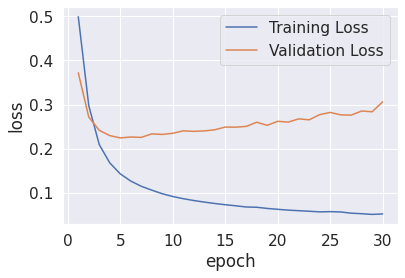

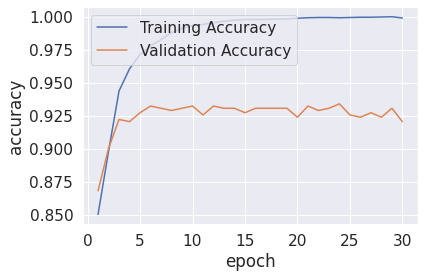

In [ ]:
epoch = np.arange(1, len(history_c.history['loss'])+1)
plt.plot(epoch, history_c.history['loss'], label='Training Loss')
plt.legend(loc='upper right')
plt.plot(epoch, history_c.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel("epoch")
plt.ylabel("loss")

plt.show()

plt.plot(epoch, history_c.history['accuracy'], label='Training Accuracy')
plt.legend(loc='upper left')
plt.plot(epoch, history_c.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='upper left')
plt.xlabel("epoch")
plt.ylabel("accuracy")

plt.show()

Use TfidfVectorizer() vectorized data to train and evaluate a model

In [ ]:
# TFIDF
model = Sequential()
optimizer1 = Adam(learning_rate=0.00003)
model.add(Dense(units=450, activation='relu', input_dim=len(vectorizer2.get_feature_names_out()), kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizer1, metrics=['accuracy'])
history_tfidf = model.fit(X_train, y_train, epochs=60, verbose=1, batch_size = 32, validation_split = 0.15)

print("Evaluate test data:")
scores_tfidf = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy:", scores_tfidf[1]*100, "%")


Epoch 1/60
158/158 [==============================] - 16s 98ms/step - loss: 1.2640 - accuracy: 0.8398 - val_loss: 1.1136 - val_accuracy: 0.8761
Epoch 2/60
158/158 [==============================] - 15s 96ms/step - loss: 0.9953 - accuracy: 0.8498 - val_loss: 0.8739 - val_accuracy: 0.8761
Epoch 3/60
158/158 [==============================] - 16s 103ms/step - loss: 0.7901 - accuracy: 0.8498 - val_loss: 0.6968 - val_accuracy: 0.8761
Epoch 4/60
158/158 [==============================] - 15s 96ms/step - loss: 0.6461 - accuracy: 0.8498 - val_loss: 0.5781 - val_accuracy: 0.8761
Epoch 5/60
158/158 [==============================] - 15s 96ms/step - loss: 0.5564 - accuracy: 0.8498 - val_loss: 0.5090 - val_accuracy: 0.8761
Epoch 6/60
158/158 [==============================] - 15s 96ms/step - loss: 0.5053 - accuracy: 0.8498 - val_loss: 0.4661 - val_accuracy: 0.8761
Epoch 7/60
158/158 [==============================] - 15s 96ms/step - loss: 0.4716 - accuracy: 0.8498 - val_loss: 0.4366 - val_accuracy

Visualize the resulting models' loss and accuracy curve

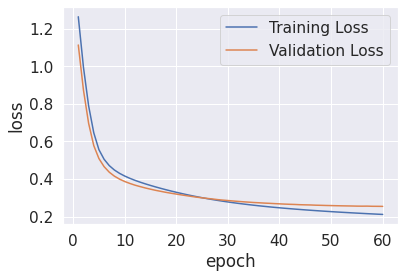

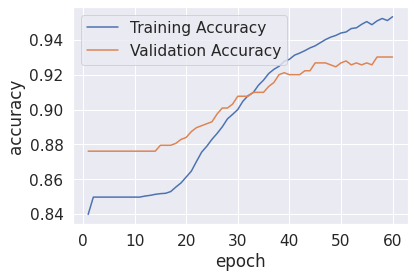

In [ ]:

epoch = np.arange(1, len(history_tfidf.history['loss'])+1)
plt.plot(epoch, history_tfidf.history['loss'], label='Training Loss')
plt.legend(loc='upper right')
plt.plot(epoch, history_tfidf.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel("epoch")
plt.ylabel("loss")

plt.show()

plt.plot(epoch, history_tfidf.history['accuracy'], label='Training Accuracy')
plt.legend(loc='upper left')
plt.plot(epoch, history_tfidf.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='upper left')
plt.xlabel("epoch")
plt.ylabel("accuracy")

plt.show()

Comparing the accuracy between the 2 trained RNNs, it is similar but the tfidvectorizer provide more stable learning curve that is less likely to overfit.

<BarContainer object of 2 artists>

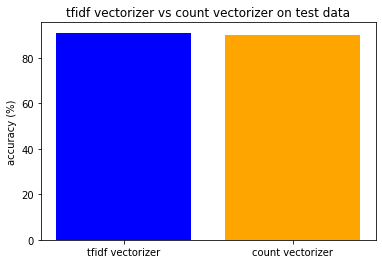

In [ ]:
plt.ylabel('accuracy (%)')
plt.title('tfidf vectorizer vs count vectorizer on test data')
plt.bar(('tfidf vectorizer', 'count vectorizer'),(scores_tfidf[1]*100, scores_c[1]*100), color=['blue','orange'])

In [ ]:
#Save the model
save_model(model)

After the model is saved, we can reload it. This way, we would not need to retrain the model, instead we can directly use it for prediction. We choose the second model as the most suitable one.

After loaded, we apply the model to predict test data.

vector_to_binary() is one of the functions defined in Cell 2 that will convert the sigmoid layer output of probabilities into 0 and 1. We use 0.5 as the threshold (more than equal to 0.5 classified as 1)

In [ ]:
# load the saved model
model = pickle.load(open('4483_model', 'rb'))

# use the model on test data (not test.json)

y_pred = model.predict(X_test)

y_pred = vector_to_binary(y_pred)

47/47 [==============================] - 1s 15ms/step


We plot the confusion matrix to compare the model prediction to the actual test data label.

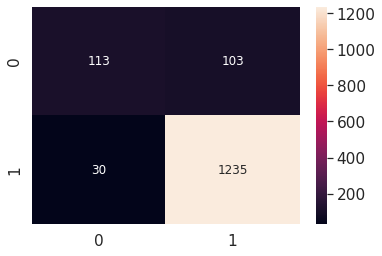

In [ ]:
# compare predicted values with actual values of test data (not test.json)
cf_matrix = confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(cf_matrix, range(2), range(2))
sb.set(font_scale=1.4) # for label size
sb.heatmap(df_cm, annot=True, annot_kws={"size": 12}, fmt='g') # font size

We save the test data comparison in csv file for future reference.

In [ ]:
# save the test data (not test.json) into a csv along with its actual sentiments
# and predicted sentiments

df_inaccurate = pd.DataFrame()
df_inaccurate['reviews']=X_test_pp
df_inaccurate['actual_sentiments']=list(y_test)
df_inaccurate['predicted_sentiments']=y_pred
df_inaccurate.to_csv("inaccurate.csv",encoding="utf-8")

df_inaccurate.head()

,reviews,actual_sentiments,predicted_sentiments
93,This is my second pair of these (one pair blac...,1,1
4285,My husband absolutely loved the t-shirt. Guy H...,1,1
3016,"I usually wear a size 9, but went with an 8, a...",1,1
4638,I just received a pair of the MIA Hepburn blac...,1,1
4531,This set is made of thin scratchy cheap fabric...,0,0


Lastly, we use the model to predict test.json data that is vectorized with TfidfVectorizer() as well. We save the result in 'submission.csv'

In [ ]:
# vectorize test.json data with saved vectorizer
vectorizer = pickle.load(open('4483_vectorizer', 'rb'))
X_t_vectorized = vectorizer2.transform(X_t).todense()

# use the saved model to predict test.json
model = pickle.load(open('4483_model', 'rb'))
y_pred_t = model.predict(X_t_vectorized)
y_pred_t_binary = vector_to_binary(y_pred_t)

ds_t['predicted_sentiments']=y_pred_t_binary

ds_t.to_csv("submission.csv",encoding="utf-8")

ds_t.head()

58/58 [==============================] - 1s 24ms/step


,reviews,predicted_sentiments
0,I bought 2 sleepers. sleeper had holes in the...,0
1,I dare say these are just about the sexiest th...,1
2,"everything about the transaction (price, deliv...",1
3,"Not bad for just a shirt. Very durable, and m...",1
4,These are truly wrinkle free and longer than t...,1
